# Formation and refinement of cells during plastic deformation
This is a notebook made for the data analysis presented in the paper "Formation and refinement of cells during plastic deformation" by Zelenika et al. It aims to provide an overview to the reader of the necessary data analysis and the underlying logic used to produces the results and plots shown in the article. This notebook follows the layout seen in the supplimentary materials of the paper. 

The various cells should provide the reader with the ability to remake all the figures shown in the paper as well as potentially manipulate the data. This Notebook has the goal of bringing these large datasets and the resulting data analysis to a large audience of material scientists and physicist who may not be used to working with the rich datasets produced by synchrotron experiments. It is the hope of the authors that this endeavour will lead to increased interest, trust and data analysis pipelines for Dark-Field X-ray Microscopy studies. 

# Import all the necessary packages 
This note book should be run in an adequate kernel with the necessary dependencies. The git repository hosting this notebook contains such a kernel titled "matlab" as part of this code is a direct translation of a legacy matlab scripts written by Henning Friis Poulsen. 

In [231]:
from DFXM.scan_functions import *
from DFXM.image_processor import inv_polefigure_colors 

# Import the data 

Load the DFXM images needed for the analysis and define the necessary system constants such as pixel size and strain levels.

In this step the files are also sorted by strain level to ensure a match with the strain list that is a user input.

All necessary global lists should also be defined here. 

In [256]:
path = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\\Documents\\DTU_Project\\data\\fit15\\'
pixel_y = 0.203; pixel_x = 0.6575; # effective pixel sizes in mu

com_phi, com_chi = load_data(path, 'com')
fwhm_phi, fwhm_chi = load_data(path, 'fwhm')

strain = [0, 0.005, 0.008, 0.013, 0.024, 0.035, 0.046, 0.046, 0.046, 0.046]

com_phi = sorted(com_phi, key=extract_number)
com_chi = sorted(com_chi, key=extract_number)
fwhm_phi = sorted(fwhm_phi, key=extract_number)
fwhm_chi = sorted(fwhm_chi, key=extract_number)


j = 6 # index of the file

i = 6 # index of the strain

# Figure 1

The next section creates a mosaicity map of the sample that has been deformed to 4.6%. It shows on overlay of the cells, defined by a Kernal Average Misorientation (KAM) calculated from the Center of Mass of each pixel (COM) mask, on the Full Width Half Max (FWHM) information of the scan. 

In [257]:
# load the COM images
Img_chi, maximum_chi, minimum_chi, average_chi, TF_chi, row_size_chi, col_size_chi, _ = process_data(path, com_chi[j], method='COM')
Img_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, com_phi[j], method='COM')

# Define the colour grid for the mosaicity map
test_grid = np.array((np.linspace(minimum_chi, maximum_chi, 25), np.linspace(minimum_phi, maximum_phi, 22)), dtype=object)
o_grid = np.array((np.linspace(minimum_chi, maximum_chi, 500), np.linspace(minimum_phi, maximum_phi, 500)), dtype=object)
colours, colour_data = inv_polefigure_colors(o_grid, test_grid)

# Create the mosaicity map
grain = find_grain(TF_chi)
_, _, grain_mask = values_histogram(Img_chi, maximum_chi, grain)

Img_chi = filter_grain(grain_mask, Img_chi, maximum_chi)
Img_phi = filter_grain(grain_mask, Img_phi, maximum_phi)

scaled_Img_chi = scale_image(Img_chi)
scaled_Img_phi = scale_image(Img_phi)

mosa, Mosa_Img = RGB_image(scaled_Img_chi, scaled_Img_phi)

# KAM calculation

Compute the KAM for the selected image and create the KAM skeleton

In [258]:
KAM = calculate_KAM(col_size_chi, row_size_chi, grain_mask, Img_chi, Img_phi, 2)

KAM_mask, skel_KAM = KAM_refine(KAM, grain_mask)

(1829, 1569)
KAM mask: percentage in walls 99.45% with KAM threshold: 0.005
KAM mask: percentage in walls 98.85% with KAM threshold: 0.006
KAM mask: percentage in walls 98.01% with KAM threshold: 0.007
KAM mask: percentage in walls 96.97% with KAM threshold: 0.008
KAM mask: percentage in walls 95.77% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 94.45% with KAM threshold: 0.01
KAM mask: percentage in walls 93.12% with KAM threshold: 0.011
KAM mask: percentage in walls 91.76% with KAM threshold: 0.012
KAM mask: percentage in walls 90.43% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 89.16% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 87.93% with KAM threshold: 0.015
KAM mask: percentage in walls 86.78% with KAM threshold: 0.016
KAM mask: percentage in walls 85.66% with KAM threshold: 0.017
KAM mask: percentage in walls 84.56% with KAM threshold: 0.018000000000000002
KAM mask: percentage in walls 83.53% with KAM 

# Plotting the mosaicity map

Here the mosaicity map and a zoomed in area of this map is plotted using the colour convention defined above.

In [259]:
# New extent limits for x-axis
x_min_new = 250
x_max_new = 810

# Remove the NaN pixels
Mosa_Img[~grain_mask] = [1, 1, 1]

# Total extent along the x-axis
total_extent_x = pixel_x * row_size_chi

# Image dimensions
_, image_width, _ = Mosa_Img.shape

# Calculate new pixel indices for cropping on x-axis
left = int((x_min_new / total_extent_x) * image_width)
right = int((x_max_new / total_extent_x) * image_width)

# Since y-axis remains unchanged, use full height
top = 0
bottom = Mosa_Img.shape[0]

mosa = np.copy(Mosa_Img)

Mosa = np.copy(Mosa_Img)
# put the skeleton on the mosaic image
Mosa_Img[skel_KAM] = [0, 0, 0]

Mosa_Img = Mosa_Img[top:bottom, left:right]
Mosa = Mosa[top:bottom, left:right]
KAM_mask = KAM_mask[top:bottom, left:right]

# Calculate the center of the image
center_y, center_x = Mosa_Img.shape[0] // 2, Mosa_Img.shape[1] // 2

# Define the region of interest (ROI) dimensions
roi_size_x = 150  
roi_size_y = 200
half_roi_size_x = roi_size_x // 2
half_roi_size_y = roi_size_y // 2

scale_bar_physical_length = 10  # e.g., 50 μm

# Calculate the scale bar length in pixels for the main image
scale_bar_pixel_length_main = scale_bar_physical_length / pixel_x

# Calculate ROI coordinates
roi_start_x = max(center_x - half_roi_size_x+15, 0)
roi_end_x = min(center_x + half_roi_size_x+15, Mosa_Img.shape[1])
roi_start_y = max(center_y - half_roi_size_y+100, 0)
roi_end_y = min(center_y + half_roi_size_y+100, Mosa_Img.shape[0])

# Calculate the scale bar length in pixels for the zoomed image
# First, find out how many pixels per micrometer in the zoomed region
zoom_factor_x = roi_size_x / (roi_end_x - roi_start_x)
zoom_factor_y = roi_size_y / (roi_end_y - roi_start_y)
pixels_per_micrometer_zoomed_x = zoom_factor_x / pixel_x
pixels_per_micrometer_zoomed_y = zoom_factor_y / pixel_y
scale_bar_pixel_length_zoomed = scale_bar_physical_length * pixels_per_micrometer_zoomed_x

# Scaling factor for the x-axis
scale_x = (x_max_new - x_min_new) / Mosa_Img.shape[1]
# Scaling factor for the y-axis
scale_y = (pixel_y * col_size_chi) / Mosa_Img.shape[0]

# Apply scaling to ROI coordinates
roi_start_x_scaled = roi_start_x * scale_x + x_min_new
roi_start_y_scaled = roi_start_y * scale_y

# Adjust ROI size if necessary based on the extent
roi_size_scaled_x = roi_size_x * scale_x
roi_size_scaled_y = roi_size_y * scale_y


# Extract the region of interest for the zoomed figure
zoomed_region = Mosa_Img[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

total_height = pixel_y * col_size_chi
adjusted_roi_start_y_scaled = total_height - roi_start_y_scaled - roi_size_scaled_y


Plotting

# Peak broadening analysis

In this section the Full Width Half Maximum (FWHM) data is extracted and plotted in the same way as the mosaicity map with the overlaid KAM skeleton to highlight the presence of cells.

In [260]:
#Load the FWHM data

FWHM_chi, maximum_chi, minimum_chi, _, _, _, _, _ = process_data(path, fwhm_chi[j], method='FWHM', grain_mask=grain_mask)
FWHM_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, fwhm_phi[j], method='FWHM', grain_mask=grain_mask)

# Combine the Phi and Chi contributions to the FWHM
FWHM_img = np.sqrt(FWHM_chi**2 + FWHM_phi**2) 
FWHM_img = FWHM_chi + FWHM_phi
FWHM_img[FWHM_img > 4] = 4




The information is treated and the ROI is defined. To highlight the presence of dislocation pileup at the cell boundaries, the KAM skeleton is ovelerlay on the FWHM map.   

An overview of the FWHM information is also plotted here.

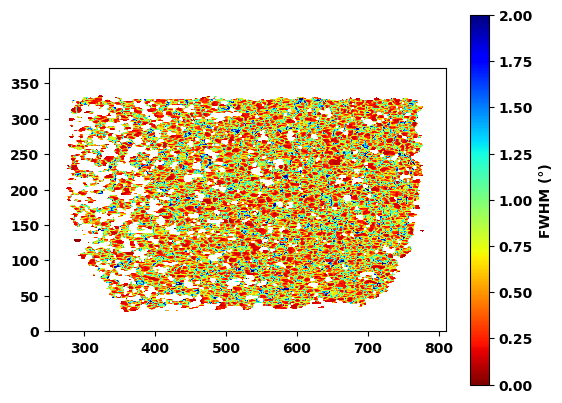

In [261]:
FWHM_img = np.where(skel_KAM, 2.5, FWHM_img)
FWHM_img = FWHM_img[top:bottom, left:right]


zoomed_region_fwhm = FWHM_img[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

plt.imshow(FWHM_img, cmap='jet_r', extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi], vmin=0, vmax=2)
plt.colorbar(label='FWHM (°)')

# Plotting the figure 

This next section deals with plottin part of Figure 1 of the publication. This publication can be founds at:.   

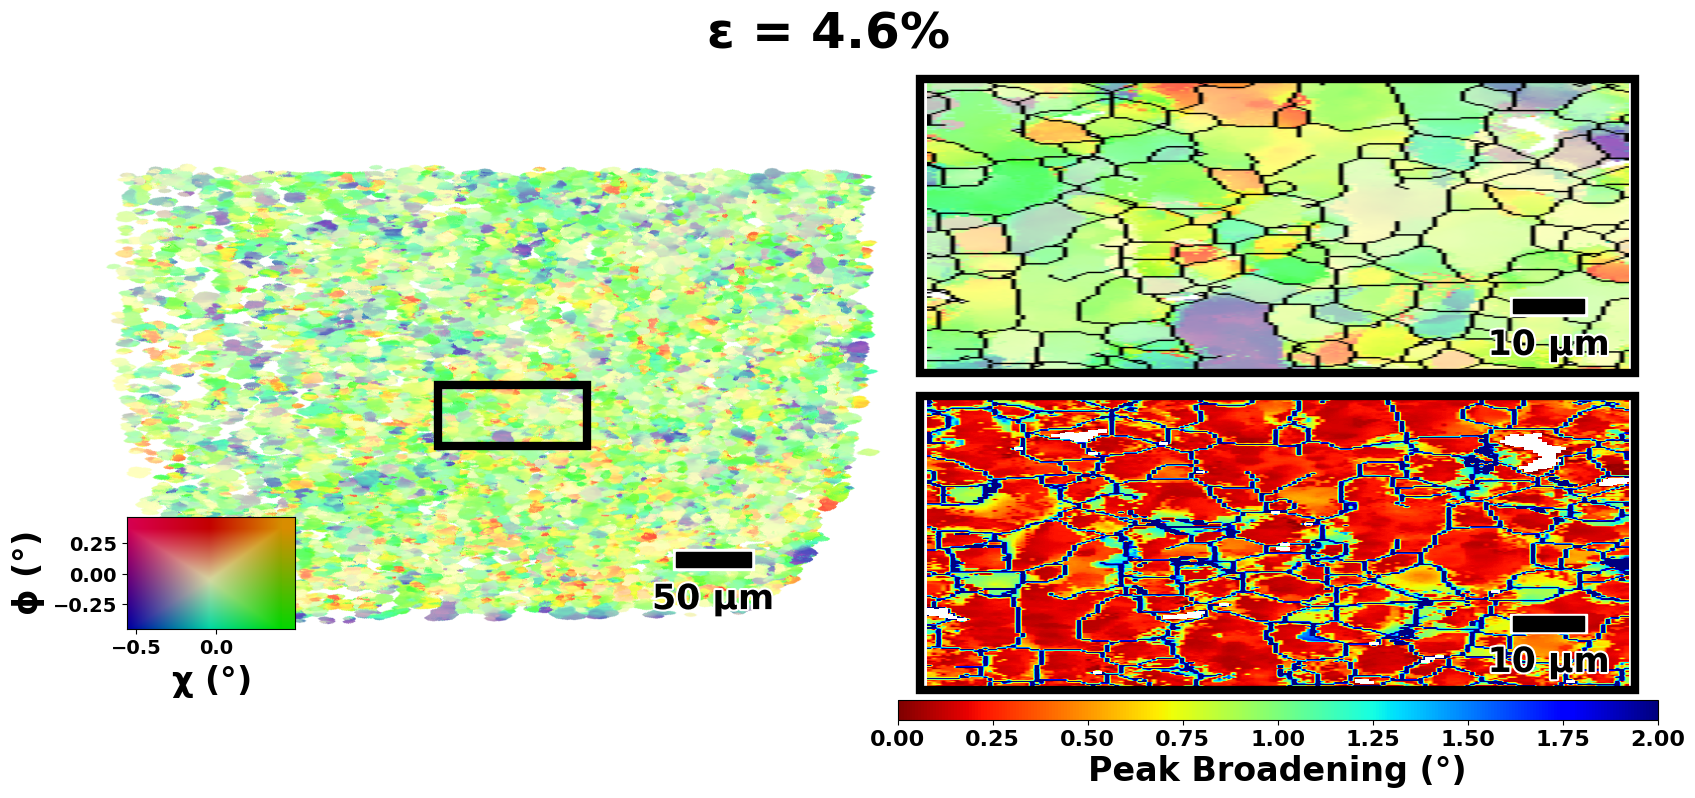

In [262]:
import matplotlib.patheffects as path_effects
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
aspect_ratio = pixel_y / pixel_x


# Initialize figure and GridSpec
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1.2, 1])
# Axes for the original image
ax0 = fig.add_subplot(gs[:, 0]) 
ax0.imshow(Mosa, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])

# Rectangle for the ROI
roi_rect = patches.Rectangle((roi_start_x_scaled, adjusted_roi_start_y_scaled),
                              roi_size_scaled_x, roi_size_scaled_y, linewidth=6, edgecolor='black', facecolor='none')
ax0.add_patch(roi_rect)

# Scale bar and its shadow
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

# Add text shadow or outline effect for scale bar label
text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')

# Inset axis for the scatter plot
inset_ax = inset_axes(ax0, width="20%", height="20%", loc='lower left', bbox_to_anchor=(0.05, 0.05, 1, 1), bbox_transform=ax0.transAxes)
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=24)
#inset_ax.set_xticks([-0.5, 0, 0.5])
inset_ax.set_ylabel('$\phi$ (°)', fontsize=24)
inset_ax.axis('on')
inset_ax.tick_params(labelsize=14)

# Axes for the zoomed region (assumed to be the second plot)
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio)
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 25, zoomed_region.shape[0] - 50)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), 
                                        scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio, -(scale_bar_thickness + 4 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness, 
                                      linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

# Adding text shadow or outline effect for scale bar label
text = ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2, f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

ax1.axis('off')

# Axes for the FWHM zoomed region (assumed to be the third plot)
ax2 = fig.add_subplot(gs[1, 1])
im = ax2.imshow(zoomed_region_fwhm, cmap='jet_r', aspect=aspect_ratio, vmin=0, vmax=2.0)
frame_fwhm = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax2.transAxes, linewidth=6, edgecolor='black', facecolor='none', clip_on=False)
ax2.add_patch(frame_fwhm)

# Add shadow and scale bar for the zoomed FWHM image
rect_shadow_zoomed_fwhm = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio, 
                                            -(scale_bar_thickness + 4 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax2.add_patch(rect_shadow_zoomed_fwhm)
rect_scale_zoomed_fwhm = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax2.add_patch(rect_scale_zoomed_fwhm)

# Add text shadow or outline effect for the scale bar label on the FWHM image
text = ax2.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2, f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

ax2.axis('off')

# Colorbar for the FWHM image
colorbar_ax = fig.add_axes([0.535, 0.16, 0.38, 0.02])
plt.colorbar(im, cax=colorbar_ax, orientation='horizontal', label='Peak Broadening (°)')
colorbar_ax.set_xlabel('Peak Broadening (°)', fontsize=24)
colorbar_ax.tick_params(labelsize=16)

# Adjust layout and add title
plt.subplots_adjust(wspace=0.01, hspace=-0.3)
plt.suptitle(f'$\epsilon$ = {strain[j]*100:.1f}%', fontsize=36, fontweight='bold', y=0.87)

# Save the figure
image_dir = r'C:\Users\adacre\OneDrive - Danmarks Tekniske Universitet\Documents\DTU_Project\data\Figures\First_sample_of_PhD\Fig_paper'
plt.savefig(os.path.join(image_dir, f'Mosa_FWHM_zoom_{j}.png'), dpi=600)

plt.show()

# Making the figures for the movies

Here we create the different image needed to create the movies presentes in the paper. Each figure is svaed individually and subsequently compiled into a movie format. This step is presented here, a small scripts that acheives this goal can be found on the github under the name: "movie_maker.py"


In [263]:
# As above here we redefine the relevant region that should be highlighted in the figure. 
roi_size_x = 200  
roi_size_y = 400
half_roi_size_x = roi_size_x // 2
half_roi_size_y = roi_size_y // 2

scale_bar_physical_length = 20  # e.g., 50 μm

# Calculate the scale bar length in pixels for the main image
scale_bar_pixel_length_main = scale_bar_physical_length / pixel_x

# Calculate ROI coordinates
roi_start_x = max(center_x - half_roi_size_x+15, 0)
roi_end_x = min(center_x + half_roi_size_x+15, Mosa_Img.shape[1])
roi_start_y = max(center_y - half_roi_size_y+100, 0)
roi_end_y = min(center_y + half_roi_size_y+100, Mosa_Img.shape[0])

# Calculate the scale bar length in pixels for the zoomed image
# First, find out how many pixels per micrometer in the zoomed region
zoom_factor_x = roi_size_x / (roi_end_x - roi_start_x)
zoom_factor_y = roi_size_y / (roi_end_y - roi_start_y)
pixels_per_micrometer_zoomed_x = zoom_factor_x / pixel_x
pixels_per_micrometer_zoomed_y = zoom_factor_y / pixel_y
scale_bar_pixel_length_zoomed = scale_bar_physical_length * pixels_per_micrometer_zoomed_x

# Scaling factor for the x-axis
scale_x = (x_max_new - x_min_new) / Mosa_Img.shape[1]
# Scaling factor for the y-axis
scale_y = (pixel_y * col_size_chi) / Mosa_Img.shape[0]

# Apply scaling to ROI coordinates
roi_start_x_scaled = roi_start_x * scale_x + x_min_new
roi_start_y_scaled = roi_start_y * scale_y

# Adjust ROI size if necessary based on the extent
roi_size_scaled_x = roi_size_x * scale_x
roi_size_scaled_y = roi_size_y * scale_y


# Extract the region of interest for the zoomed figure
zoomed_region = Mosa_Img[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

total_height = pixel_y * col_size_chi
adjusted_roi_start_y_scaled = total_height - roi_start_y_scaled - roi_size_scaled_y

# Mosaicity image with KAM skeleton

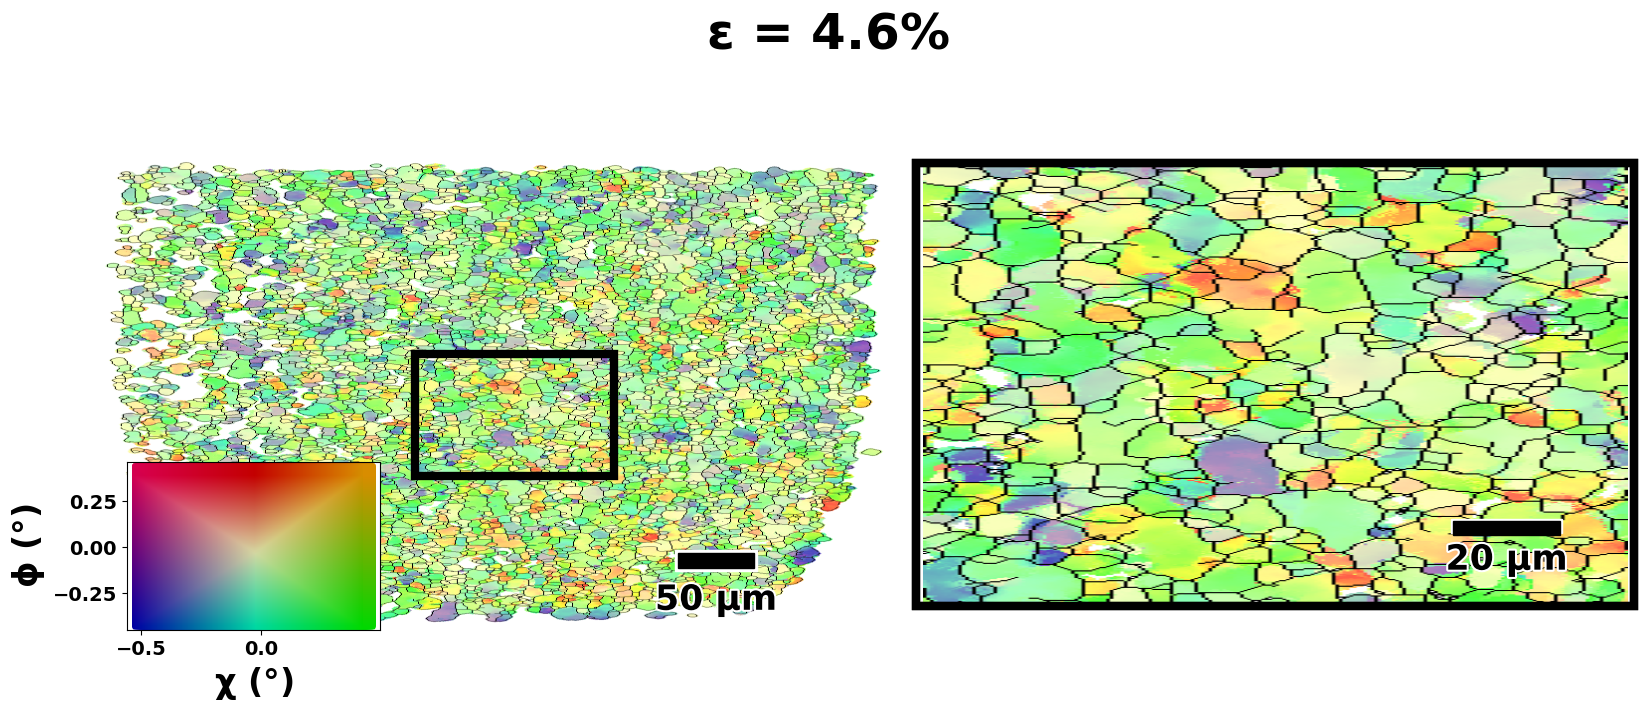

In [264]:

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1],wspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(Mosa_Img, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])
# Highlight the ROI with a red rectangle
roi_rect = patches.Rectangle((roi_start_x_scaled, adjusted_roi_start_y_scaled),
                              roi_size_scaled_x, roi_size_scaled_y, linewidth=6, edgecolor='black', facecolor='none')
ax0.add_patch(roi_rect)
# Add scale bar
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
# Draw a larger, lighter rectangle behind the original rectangle to create a shadow/bright outline effect
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)

# Draw the original rectangle
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')  # Turn off axis for a cleaner look

# Create an inset axis in the bottom left corner for the scatter plot
inset_ax = inset_axes(ax0, width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.05, 0.05, 1, 1), bbox_transform=ax0.transAxes)

# Plot the scatter plot in the inset axis
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=24)
inset_ax.set_ylabel('$\phi$ (°)', fontsize=24)
#inset_ax.set_xticks([-0.5, 0, 0.5])
inset_ax.tick_params(labelsize=14)

# Optionally, adjust the appearance of the inset_ax as needed, e.g., remove axis labels or set limits
inset_ax.axis('on')  # for a cleaner look without axis labels

# Display the zoomed-in region on the second subplot
aspect_ratio = pixel_y / pixel_x
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio)  # Set the custom aspect ratio
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', 
                          facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 50, zoomed_region.shape[0] - 75)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), 
                                        scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio,
                                          -(scale_bar_thickness + 5 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness+3, 
                                      linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

text = ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2,
                 f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])


ax1.add_patch(frame)
ax1.axis('off')

plt.suptitle(f'$\epsilon$ = {strain[j]*100:.1f}%', fontsize=36, fontweight='bold', y=0.87)

image_dir = r'C:\Users\adacre\OneDrive - Danmarks Tekniske Universitet\Documents\DTU_Project\data\Figures\First_sample_of_PhD\videos\Mosa_with_KAM'
plt.savefig(os.path.join(image_dir, f'Strain_step_{i}.png'), dpi=300) 
plt.show()


# Mosiaicity map withtout KAM skeleton

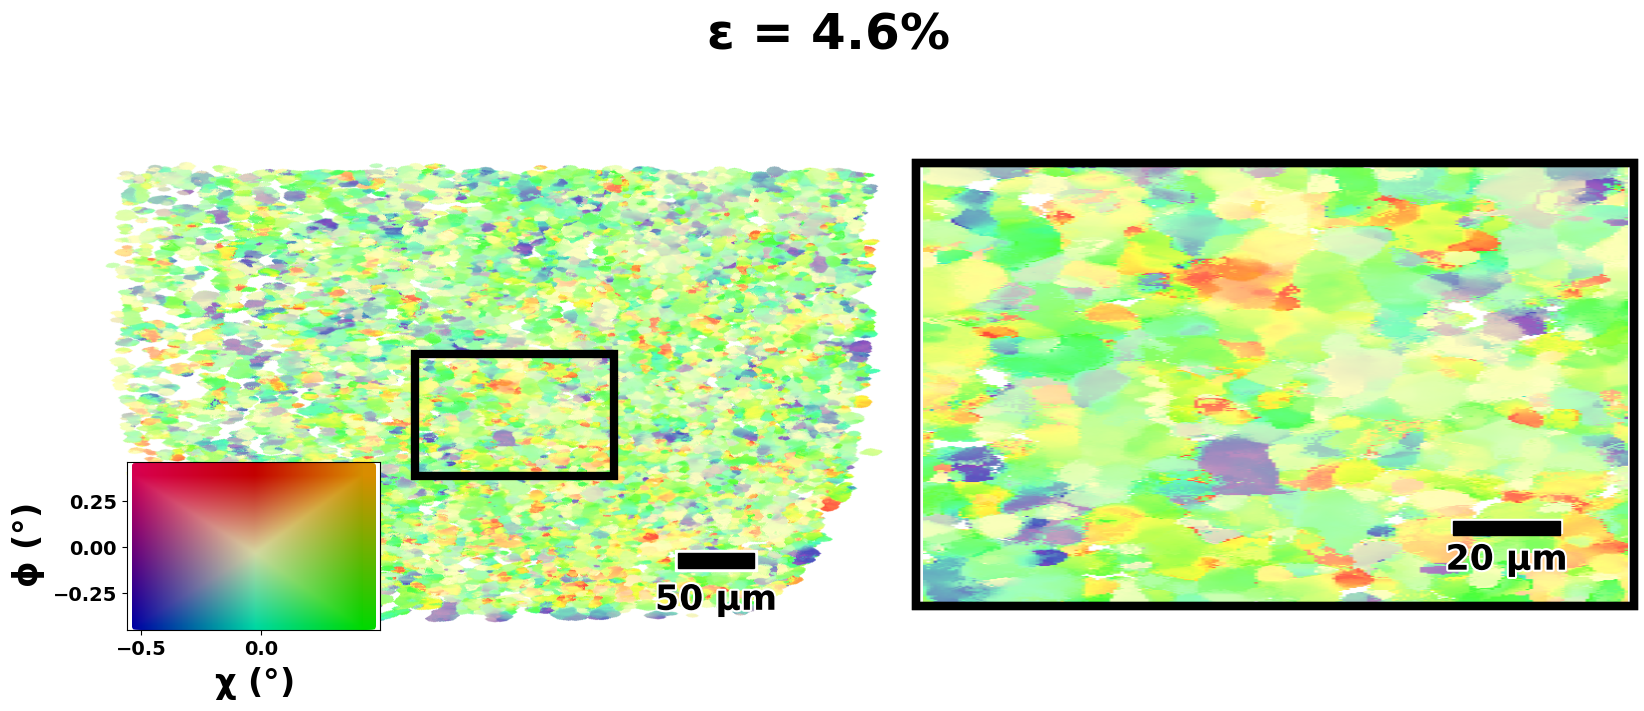

In [265]:
zoomed_region = Mosa[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1], wspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(Mosa, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])
# Highlight the ROI with a red rectangle
roi_rect = patches.Rectangle((roi_start_x_scaled, adjusted_roi_start_y_scaled),
                              roi_size_scaled_x, roi_size_scaled_y, linewidth=6, edgecolor='black', facecolor='none')
ax0.add_patch(roi_rect)
# Add scale bar
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
# Draw a larger, lighter rectangle behind the original rectangle to create a shadow/bright outline effect
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)

# Draw the original rectangle
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')  # Turn off axis for a cleaner look

# Create an inset axis in the bottom left corner for the scatter plot
inset_ax = inset_axes(ax0, width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.05, 0.05, 1, 1), bbox_transform=ax0.transAxes)

# Plot the scatter plot in the inset axis
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=24)
inset_ax.set_ylabel('$\phi$ (°)', fontsize=24)
#inset_ax.set_xticks([-0.5, 0, 0.5])
inset_ax.tick_params(labelsize=14)


# Optionally, adjust the appearance of the inset_ax as needed, e.g., remove axis labels or set limits
inset_ax.axis('on')  # for a cleaner look without axis labels

# Display the zoomed-in region on the second subplot
aspect_ratio = pixel_y / pixel_x
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio)  # Set the custom aspect ratio
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', 
                          facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 50, zoomed_region.shape[0] - 75)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), 
                                        scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio,
                                          -(scale_bar_thickness + 5 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness+3, 
                                      linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

text = ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2,
                 f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])


ax1.add_patch(frame)
ax1.axis('off')
plt.suptitle(f'$\epsilon$ = {strain[j]*100:.1f}%', fontsize=36, fontweight='bold', y=0.87)

image_dir = r'C:\Users\adacre\OneDrive - Danmarks Tekniske Universitet\Documents\DTU_Project\data\Figures\First_sample_of_PhD\videos\Mosa_no_KAM'
plt.savefig(os.path.join(image_dir, f'Strain_step_{i}.png'), dpi=300) 
plt.show()


# KAM filter map

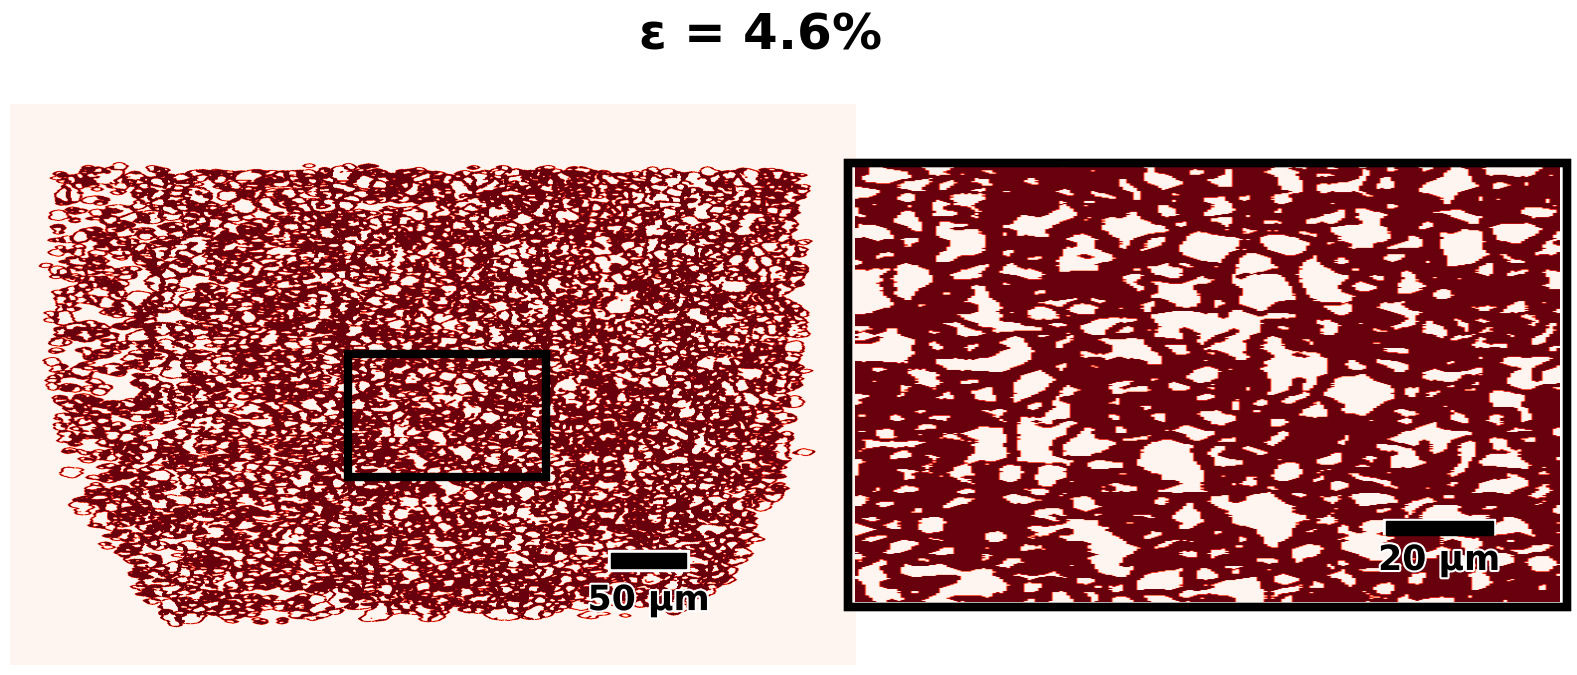

In [266]:
zoomed_region=KAM_mask[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1], wspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(KAM_mask, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi], cmap='Reds')
# Highlight the ROI with a red rectangle
roi_rect = patches.Rectangle((roi_start_x_scaled, adjusted_roi_start_y_scaled),
                              roi_size_scaled_x, roi_size_scaled_y, linewidth=6, edgecolor='black', facecolor='none')
ax0.add_patch(roi_rect)
# Add scale bar
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
# Draw a larger, lighter rectangle behind the original rectangle to create a shadow/bright outline effect
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)

# Draw the original rectangle
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')  # Turn off axis for a cleaner look

# Display the zoomed-in region on the second subplot
aspect_ratio = pixel_y / pixel_x
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio, cmap ='Reds')  # Set the custom aspect ratio
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', 
                          facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 50, zoomed_region.shape[0] - 75)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), 
                                        scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio,
                                          -(scale_bar_thickness + 5 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness+3, 
                                      linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

text = ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2,
                 f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])


ax1.add_patch(frame)
ax1.axis('off')

plt.suptitle(f'$\epsilon$ = {strain[j]*100:.1f}%', fontsize=36, fontweight='bold', y=0.87)

image_dir = r'C:\Users\adacre\OneDrive - Danmarks Tekniske Universitet\Documents\DTU_Project\data\Figures\First_sample_of_PhD\videos\KAM_filter'
plt.savefig(os.path.join(image_dir, f'strain_step_{i}.png'), dpi=300) 
plt.show()


# Peak Broadening map KAM skeleton overlay

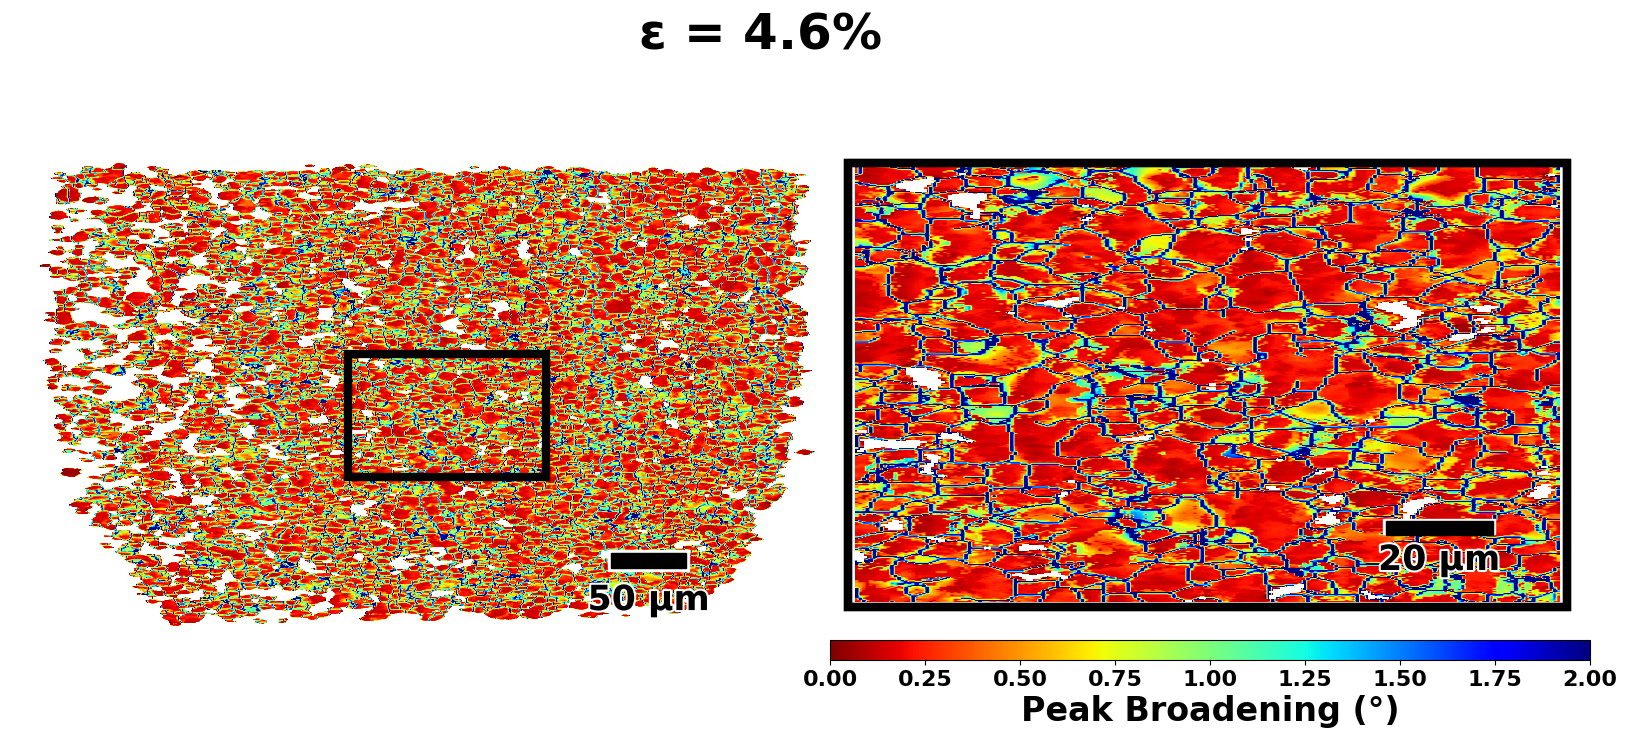

In [267]:
zoomed_region = FWHM_img[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1], wspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(FWHM_img, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi], cmap='jet_r', vmin= 0, vmax = 2)
# Highlight the ROI with a red rectangle
roi_rect = patches.Rectangle((roi_start_x_scaled, adjusted_roi_start_y_scaled),
                              roi_size_scaled_x, roi_size_scaled_y, linewidth=6, edgecolor='black', facecolor='none')
ax0.add_patch(roi_rect)
# Add scale bar
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
# Draw a larger, lighter rectangle behind the original rectangle to create a shadow/bright outline effect
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)

# Draw the original rectangle
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')  # Turn off axis for a cleaner look

# Display the zoomed-in region on the second subplot
aspect_ratio = pixel_y / pixel_x
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio, cmap='jet_r', vmin= 0, vmax = 2)  
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', 
                          facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 50, zoomed_region.shape[0] - 75)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), 
                                        scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio,
                                          -(scale_bar_thickness + 5 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness+3, 
                                      linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

text = ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2,
                 f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])


ax1.add_patch(frame)
ax1.axis('off')
# Colorbar for the FWHM image
colorbar_ax = fig.add_axes([0.535, 0.22, 0.38, 0.02])
plt.colorbar(im, cax=colorbar_ax, orientation='horizontal', label='Peak Broadening (°)')
colorbar_ax.set_xlabel('Peak Broadening (°)', fontsize=24)
colorbar_ax.tick_params(labelsize=16)

plt.suptitle(f'$\epsilon$ = {strain[j]*100:.1f}%', fontsize=36, fontweight='bold', y=0.87)

image_dir = r'C:\Users\adacre\OneDrive - Danmarks Tekniske Universitet\Documents\DTU_Project\data\Figures\First_sample_of_PhD\videos\FWHM'
plt.savefig(os.path.join(image_dir, f'strain_step_{i}.png'), dpi=300) 
plt.show()


# Figure 4

This figure aime to look at the some characteristic feature of the cell formations. The aim here is to characterise the cell sizes, the orientation relationships between a cell and its neighbours, as well as characterise the distribution of strain or dislocation density build-up in the sample through a measure of the peak-broading. 

The first step is to formally define the cells and the surrounding neighbours. This is done by defining the different regon defined by the KAM skeleton. Then some of the cells are filtered out is they are too large (these cannot yet be considered cells) or if they are too small (these are not real, only artefacts created by the analysis). 

Once these regions are found we can then determine the neighbouring cells and create a dictionnary containing each cell and a list of neighbours. The algorithm created to find the neighbours is very simple and I am sure that more efficient and robust alternatives exist, however for this use case this was deemed sufficient.


In [ ]:
regions, labeled_array = find_regions(skel_KAM)
filtered_regions = filter_regions(regions, mosa)
filtered_regions = [prop for prop in filtered_regions if prop.area * pixel_x * pixel_y <= 400]

neighbours_dict = find_neighbours(filtered_regions, labeled_array)

Number of regions: 5738
Number of filtered regions: 4073


Dilating masks:  12%|█▏        | 508/4073 [00:14<01:44, 34.23it/s]


KeyboardInterrupt: 

Once the cells and neighbours are defined we can proceed with more in depth analysis and peak into what is occuring during the formation of these sub-grain structures. Because of the large field of view that can be probed using DFXM, it is possible to get meaning ful stastistical information from this analysis. 

In the following part, we will look inte the various statistical distrbution that define the strucutres formed during the plastic deformation. We will look at the size distribution of the cells, the misorientation between a cell and its neigbours as well as the distribution of strain or dislocation inside the sample.

Average misorientation: 0.32822689349898815
12010
[0.6948386801664479, 0.18272546761389954, 0.7477065797708398, 0.18123414204935578, 0.24806116882746898, 0.3212109150645203, 0.23226389181486976, 0.34027172469211314, 0.03899031778899022, 0.5715618023944388, 0.11481244663643295, 0.14014302554584857, 0.1468609577220181, 0.2930850697539496, 0.09048834007225255, 0.19251953972654345, 0.17524001485139246, 0.5121206343277611, 0.053982470152793866, 0.19333283913468824, 0.13387801946413708, 0.29258596772252526, 0.1828076653540624, 0.09784367194269841, 0.4640376926799453, 0.6476530638723059, 0.05756420698538083, 0.10341520037667666, 0.11108059512088943, 0.5858213039783722, 0.5645198869799997, 0.3726967587061251, 0.24603287825563172, 0.09128630314819092, 0.14820745391162485, 0.30944559829878004, 0.526448699277012, 0.45568929004181974, 0.1788204513993775, 0.19421489929897798, 0.14691623343274626, 0.45970895853374855, 0.22026304937741134, 0.4921684990591776, 0.6649523729279663, 0.5649877380416902, 0

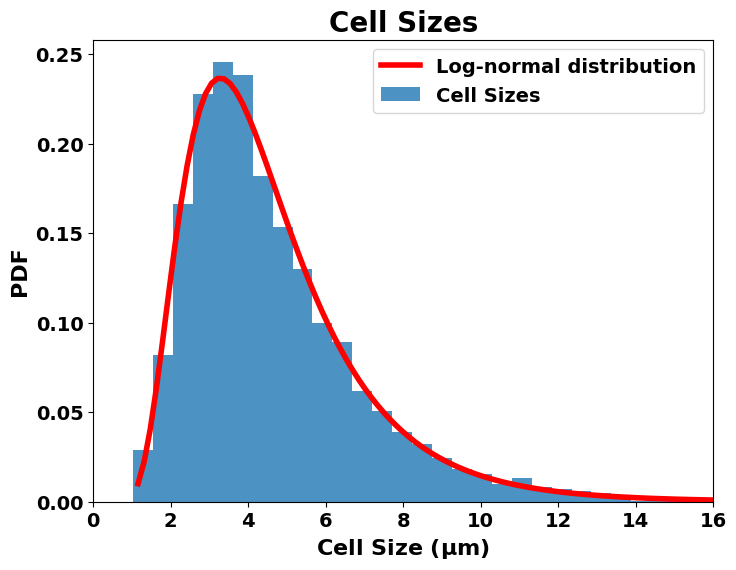

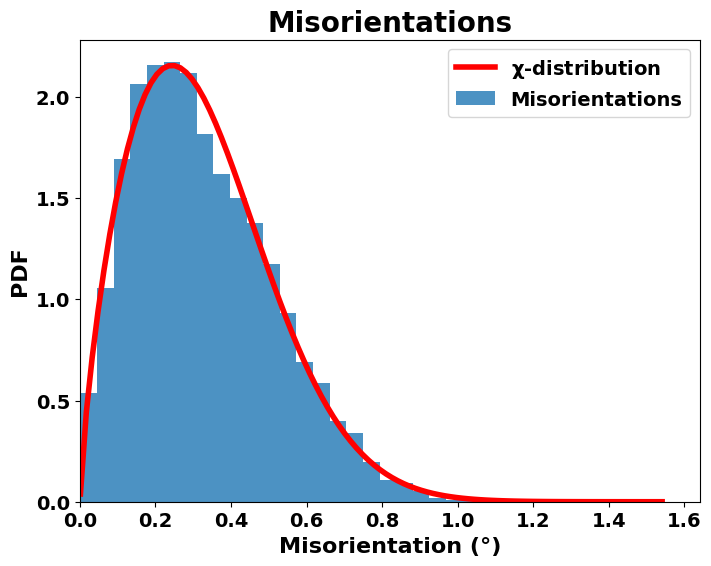

In [ ]:
# Calculate the misorientations

misorientations = neighbour_misorientation(filtered_regions, neighbours_dict, Img_chi, Img_phi) #Here we need to take the data before scaling to ensure that the misorientation is calculated correctly on the actual data

print('Average misorientation:', np.mean(misorientations))

print(len(misorientations))
print(misorientations)

# Look at the distribution of cell sizes
sizes = [np.sqrt(prop.area*pixel_x*pixel_y) for prop in filtered_regions]
fig, ax = plt.subplots(figsize=(8, 6))
fit_and_plot_lognorm(sizes, ax, 'Cell Sizes')

# Save the figure
#image_dir = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\Documents\\DTU_Project\\data\\Figures\\First_sample_of_PhD\\final_figures'
#plt.savefig(os.path.join(image_dir, f'cell_size__{strain[j]}_{j}.png'), dpi=600)

print('Average grain size:', np.mean(sizes))

# Look at the distribution of misorientations

fig, ax = plt.subplots(figsize=(8, 6))
fit_and_plot_chi(misorientations, ax, 'Misorientations')
#image_dir = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\Documents\\DTU_Project\\data\\Figures\\First_sample_of_PhD\\final_figures'
#plt.savefig(os.path.join(image_dir, f'misorientations__{strain[j]}_{j}.png'), dpi=600)


Now we want to take a look at what is going on inside the cells. In order to do this, we plot the distribution of FWHM values accros the image. This is a proxy for dislocation densities. 

In [ ]:
skel_KAM = skel_KAM[top:bottom, left:right]
FWHM_img[skel_KAM] = np.nan  # Set the skeletonized pixels to NaN

FWHM_hist = np.concatenate(FWHM_img).ravel() # Flatten the FWHM image to a 1D array

FWHM_hist = FWHM_hist[~np.isnan(FWHM_hist)]



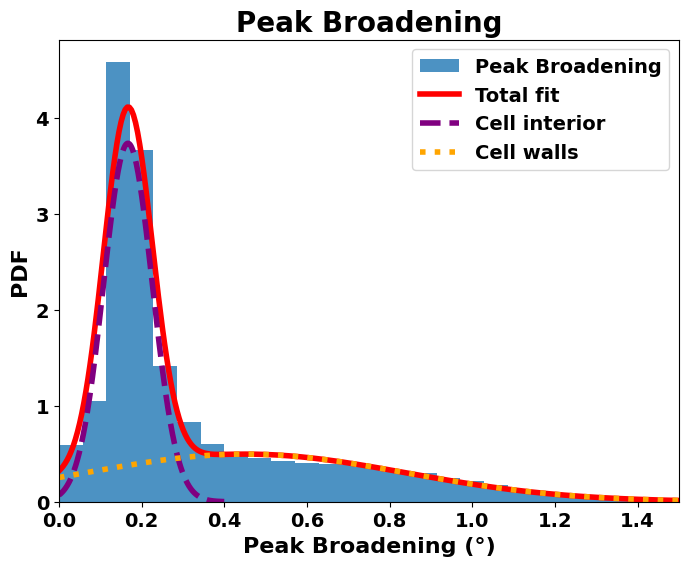

In [ ]:
# Prepare the histogram data for fitting
hist, bin_edges = np.histogram(FWHM_hist, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the fit parameters
initial_guess = [1, 0.15, 0.1, 1, 0.5, 0.1]

# Perform the curve fitting
bounds = ([0, -np.inf, 0, 0, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
popt, pcov = curve_fit(two_gaussians, bin_centers, hist, p0=initial_guess, bounds = bounds)

# Generate a fine grid of x-values for a smooth plot
x_fine = np.linspace(min(FWHM_hist), 2, 400)
x_fine_1 = np.linspace(min(FWHM_hist), 0.4, 400)

# Plotting the fit result
plt.figure(figsize=(8, 6))
plt.hist(FWHM_hist, bins=35, density=True, range=(0, 2), label='Peak Broadening', alpha = 0.8)
plt.plot(x_fine, two_gaussians(x_fine, *popt), color='red', label='Total fit', lw=4)
plt.plot(x_fine_1, gaussian(x_fine_1, *popt[:3]), color='purple', label='Cell interior', lw=4, ls='--')
plt.plot(x_fine, gaussian(x_fine, *popt[3:]), color='orange', label='Cell walls', lw=4, ls='dotted')
plt.xlabel('Peak Broadening (°)', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Peak Broadening', fontsize=20)
plt.xlim(0, 1.5)
plt.legend(fontsize=14)


image_dir = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\Documents\\DTU_Project\\data\\Figures\\First_sample_of_PhD\\final_figures'
#plt.savefig(os.path.join(image_dir, f'peakbroadening__{strain[j]}_{j}.png'), dpi=600)
plt.show()

# Figure for cell map movie

In [ ]:
Cell_Img1 = np.ones_like(mosa) # Create an image with the average orientation of each cell
for ii in range(1, len(filtered_regions)):  # Skip exterior nr_cells + 1
    cellPixels = filtered_regions[ii].coords
    cell_ave_Chi = np.median(mosa[cellPixels[:, 0], cellPixels[:, 1], 0])
    cell_ave_Phi = np.median(mosa[cellPixels[:, 0], cellPixels[:, 1], 1])
    cell_ave_nada = np.median(mosa[cellPixels[:, 0], cellPixels[:, 1], 2])
    for row, col in cellPixels:
        Cell_Img1[row, col, 0] = cell_ave_Chi
        Cell_Img1[row, col, 1] = cell_ave_Phi
        Cell_Img1[row, col, 2] = cell_ave_nada

Cell_Img1 = Cell_Img1[top:bottom, left:right]

Cell_Img1[skel_KAM] = [0, 0, 0]

zoomed_region = Cell_Img1[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

# Here I stil need to define the regions in order to compute the cells. Should be done sooner rather than later....

zoomed_region = Cell_Img1[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(Cell_Img1, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])
# Highlight the ROI with a red rectangle
rect = patches.Rectangle((roi_start_x_scaled, roi_start_y_scaled), roi_size_scaled_x, roi_size_scaled_y, linewidth=3, edgecolor='black', facecolor='none')
ax0.add_patch(rect)
# Add scale bar
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
# Draw a larger, lighter rectangle behind the original rectangle to create a shadow/bright outline effect
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)

# Draw the original rectangle
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')  # Turn off axis for a cleaner look

# Create an inset axis in the bottom left corner for the scatter plot
inset_ax = inset_axes(ax0, width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.05, 0.05, 1, 1), bbox_transform=ax0.transAxes)

# Plot the scatter plot in the inset axis
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=16)
inset_ax.set_ylabel('$\phi$ (°)', fontsize=16)

# Optionally, adjust the appearance of the inset_ax as needed, e.g., remove axis labels or set limits
inset_ax.axis('on')  # for a cleaner look without axis labels

# Display the zoomed-in region on the second subplot
aspect_ratio = pixel_y / pixel_x
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio)  # Set the custom aspect ratio
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', 
                          facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 50, zoomed_region.shape[0] - 75)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), 
                                        scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio,
                                          -(scale_bar_thickness + 5 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness+3, 
                                      linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

text = ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2,
                 f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])


ax1.add_patch(frame)
ax1.axis('off')

plt.suptitle('$\epsilon$ = ' + str(strain[i-1]), fontsize=30, fontweight='bold', y=0.85)
# Save the figure with both the original image with ROI highlighted and the zoomed-in view, both framed in red
#plt.savefig(os.path.join(image_dir, f'Mosa_Image_{i}.png'), dpi=300) 
plt.show()


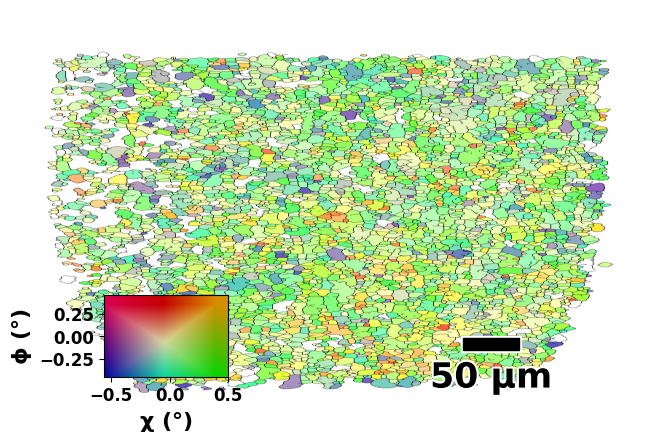

In [ ]:
# Initialize figure and GridSpec
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1.2, 1])
# Axes for the original image
ax0 = fig.add_subplot(gs[:, :]) 
ax0.imshow(Cell_Img1, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])

# Scale bar and its shadow
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

# Text and shadow
text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')

# Inset axis for the scatter plot
inset_ax = inset_axes(ax0, width="20%", height="20%", loc='lower left', bbox_to_anchor=(0.12, 0.09, 1, 1), bbox_transform=ax0.transAxes)
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=16)
inset_ax.set_xticks([-0.5, 0, 0.5]) # make sure the ticks are displayed nicely for 4.6% deformed sample
inset_ax.set_ylabel('$\phi$ (°)', fontsize=16)
inset_ax.axis('on')
inset_ax.tick_params(labelsize=12)

ax0.axis('off')

image_dir = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\Documents\\DTU_Project\\data\\Figures\\First_sample_of_PhD\\final_figures'
#plt.savefig(os.path.join(image_dir, f'mosa_withskel_{strain[j]}_{j}.png'), dpi=600)

Here we combine all these figures into one as shown in the publication.

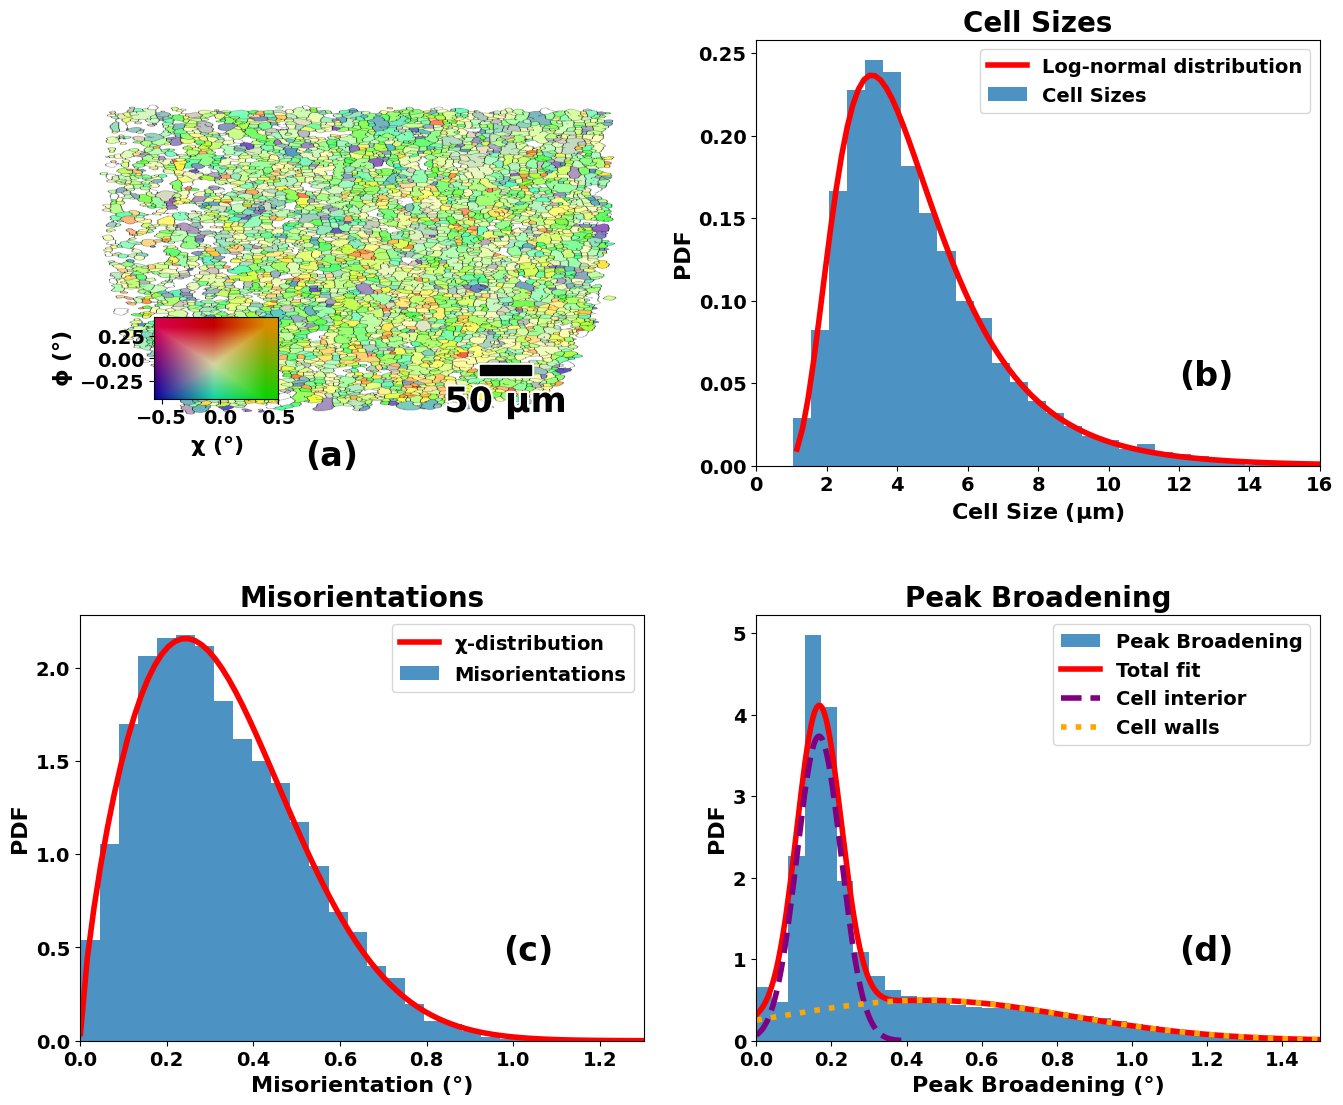

In [ ]:
fig = plt.figure(figsize=(16, 13))   
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], hspace=0.35) # Create a 2x2 grid

ax0 = fig.add_subplot(gs[0, 0]) # First row, first column
ax0.text(0.4, 0.0, '(a)', transform=ax0.transAxes, fontsize=24, fontweight='bold', va='top')
ax0.imshow(Cell_Img1, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])

# Scale bar and its shadow
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

# Text and shadow
text = ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
ax0.axis('off')

# Inset axis for the scatter plot
inset_ax = inset_axes(ax0, width="22%", height="22%", loc='lower left', bbox_to_anchor=(0.12, 0.09, 1, 1), bbox_transform=ax0.transAxes)
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=16)
inset_ax.set_xticks([-0.5, 0, 0.5]) # make sure the ticks are displayed nicely for 4.6% deformed sample
inset_ax.set_ylabel('$\phi$ (°)', fontsize=16)
inset_ax.axis('on')
inset_ax.tick_params(labelsize=14)

ax0.axis('off')

ax1 = fig.add_subplot(gs[0, 1]) # First row, second column
ax1.text(0.75, 0.25, '(b)', transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top')
fit_and_plot_lognorm(sizes, ax1, 'Cell Sizes')

ax2 = fig.add_subplot(gs[1, 0]) # Second row, first column
ax2.text(0.75, 0.25, '(c)', transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top')
fit_and_plot_chi(misorientations, ax2, 'Misorientations')
ax2.set_xlim(0, 1.3)

ax3 = fig.add_subplot(gs[1, 1]) # Second row, second column
ax3.text(0.75, 0.25, '(d)', transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top')
ax3.hist(FWHM_hist, bins=35, density=True, range=(0, 1.5), label='Peak Broadening', alpha=0.8)
# Plot the total fit
ax3.plot(x_fine, two_gaussians(x_fine, *popt), color='red', label='Total fit', lw=4)
# Plot the fit for the cell interior
ax3.plot(x_fine_1, gaussian(x_fine_1, *popt[:3]), color='purple', label='Cell interior', lw=4, ls='--')
# Plot the fit for the cell walls
ax3.plot(x_fine, gaussian(x_fine, *popt[3:]), color='orange', label='Cell walls', lw=4, ls='dotted')

# Set labels, title, limits, and legend for ax3
ax3.set_xlabel('Peak Broadening (°)', fontsize=16)
ax3.set_ylabel('PDF', fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_title('Peak Broadening', fontsize=20)
ax3.set_xlim(0, 1.5)
ax3.legend(fontsize=14)

# Save the figure
image_dir = r'C:\Users\adacre\OneDrive - Danmarks Tekniske Universitet\Documents\DTU_Project\data\Figures\First_sample_of_PhD\Fig_paper'
plt.savefig(os.path.join(image_dir, f'cell_statistics_{j}.png'), dpi=600)

plt.show()


# Analysis of the different strain steps

Up to this point all analysis and plots has focussed on a single strain step, however in order to understand the evolution of the strucutres that form during the onset of plastic deformation, we must look at all the the step. In the following cells this will be achieved by processing all the files one after the other and then plotting the information that is displayed in the various figure. 

This section takes quite a while to run. Please feel free to optimise the various algorithms used, I am not a computer scientist or a programmer and therfore the scripts are very primitive. Only a small attempt at some parallelisation has been done with the help of our favourite chat bot. 

In this part the same analysis that was done for a single sample is carried out on all samples by creating a simple for loop. Because of this only the code is give with little to no additional comments or explanations. 

In [ ]:
strain = [0, 0.005, 0.008, 0.013, 0.024, 0.035, 0.046, 0.046, 0.046, 0.046]

mean_sizes, std_sizes, v_frac, mean_misorientations, std_misorientations, mean_gauss1, std_gauss1, mean_gauss2, std_gauss2, cell_count, mean_chi, mean_phi, mean_fwhm = [], [], [], [], [], [], [], [], [], [], [], [], []

for i in range(len(com_chi)):
    Img_chi, maximum_chi, minimum_chi, average_chi, TF_chi, row_size_chi, col_size_chi, _ = process_data(path, com_phi[i], method='COM')
    Img_phi, maximum_phi, _, _, _, _, _, _ = process_data(path, com_chi[i], method='COM')

    # Create the mosaicity map
    grain = find_grain(TF_chi)
    _, _, grain_mask = values_histogram(Img_chi, maximum_chi, grain)

    Img_chi = filter_grain(grain_mask, Img_chi, maximum_chi)
    Img_phi = filter_grain(grain_mask, Img_phi, maximum_phi)

    scaled_Img_chi = scale_image(Img_chi)
    scaled_Img_phi = scale_image(Img_phi)

    mosa, Mosa_Img = RGB_image(scaled_Img_chi, scaled_Img_phi)

    FWHM_chi, maximum_chi, minimum_chi, _, _, _, _, _ = process_data(path, fwhm_chi[i], method='FWHM', grain_mask=grain_mask)

    FWHM_chi[FWHM_chi > 2] = np.nan
    mean_chi.append(np.nanmean(FWHM_chi))
    FWHM_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, fwhm_phi[i], method='FWHM', grain_mask=grain_mask)
    FWHM_phi[FWHM_phi > 2] = np.nan
    mean_phi.append(np.nanmean(FWHM_phi))

    KAM = calculate_KAM(col_size_chi, row_size_chi, grain_mask, Img_chi, Img_phi, 2)

    KAM_mask, skel_KAM = KAM_refine(KAM, grain_mask)

    FWHM_img = np.sqrt(FWHM_chi**2 + FWHM_phi**2) 

    mean_fwhm.append(np.nanmean(FWHM_img))
    #FWHM_img = FWHM_chi + FWHM_phi
    FWHM_img[FWHM_img > 4] = 4

    regions, labeled_array = find_regions(skel_KAM)
    filtered_regions = filter_regions(regions, mosa)
    filtered_regions = [prop for prop in filtered_regions if prop.area * pixel_x * pixel_y <= 400]

    cell_count.append(len(filtered_regions))

    neighbours_dict = find_neighbours(filtered_regions, labeled_array)

    misorientations = neighbour_misorientation(filtered_regions, neighbours_dict, Img_chi, Img_phi) #Here we need to take the data before scaling to ensure that the misorientation is calculated correctly on the actual data

    print('Average misorientation:', np.mean(misorientations))

    mean_misorientations.append(np.mean(misorientations))
    std_misorientations.append(np.std(misorientations))

    # Look at the distribution of cell sizes
    sizes = [np.sqrt(prop.area*pixel_x*pixel_y) for prop in filtered_regions]

    mean_sizes.append(np.mean(sizes))
    std_sizes.append(np.std(sizes))

    areas, _ = area_sizes(filtered_regions, pixel_x, pixel_y)

    vf = volume_fraction(areas, grain_mask, skel_KAM, pixel_x, pixel_y)

    v_frac.append(vf)

    FWHM_img[skel_KAM] = np.nan  # Set the skeletonized pixels to NaN

    FWHM_img[~grain] = np.nan  # Set the non-grain pixels to NaN

    FWHM_hist = np.concatenate(FWHM_img).ravel() # Flatten the FWHM image to a 1D array

    FWHM_hist = FWHM_hist[~np.isnan(FWHM_hist)]

    if len(areas) > 500:

        # Prepare the histogram data for fitting
        hist, bin_edges = np.histogram(FWHM_hist, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Initial guesses for the fit parameters
        initial_guess = [1, 0.15, 0.1, 1, 0.5, 0.1]

        # Perform the curve fitting
        bounds = ([0, -np.inf, 0, 0, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        popt, pcov = curve_fit(two_gaussians, bin_centers, hist, p0=initial_guess, bounds = bounds)

        mean_gauss1.append(popt[1])
        std_gauss1.append(np.sqrt(np.diag(pcov))[1])
        mean_gauss2.append(popt[4])
        std_gauss2.append(np.sqrt(np.diag(pcov))[4])
    else:
        mean_gauss1.append(np.nan)
        std_gauss1.append(np.nan)
        mean_gauss2.append(np.nan)
        std_gauss2.append(np.nan)

    mosa = np.copy(Mosa_Img)

    Cell_Img1 = np.ones_like(mosa) # Create an image with the average orientation of each cell
    for ii in range(1, len(filtered_regions)):  # Skip exterior nr_cells + 1
        cellPixels = filtered_regions[ii].coords
        cell_ave_Chi = np.median(mosa[cellPixels[:, 0], cellPixels[:, 1], 0])
        cell_ave_Phi = np.median(mosa[cellPixels[:, 0], cellPixels[:, 1], 1])
        cell_ave_nada = np.median(mosa[cellPixels[:, 0], cellPixels[:, 1], 2])
        for row, col in cellPixels:
            Cell_Img1[row, col, 0] = cell_ave_Chi
            Cell_Img1[row, col, 1] = cell_ave_Phi
            Cell_Img1[row, col, 2] = cell_ave_nada
            
    Cell_Img1[skel_KAM] = [0, 0, 0]
    Cell_Img1 = Cell_Img1[top:bottom, left:right]
    
    #plt.imshow(Cell_Img1, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])
    #plt.show()



(1919, 1580)
KAM mask: percentage in walls 41.22% with KAM threshold: 0.005
Number of regions: 323
Number of filtered regions: 47


Dilating masks: 100%|██████████| 46/46 [00:00<00:00, 53.02it/s]
Finding neighbours: 46it [00:00, 154.73it/s]


Average misorientation: 0.006083224092059436
Volume fraction: 0.13%
(1829, 1569)
KAM mask: percentage in walls 46.36% with KAM threshold: 0.005
Number of regions: 558
Number of filtered regions: 100


Dilating masks: 100%|██████████| 100/100 [00:01<00:00, 56.31it/s]
Finding neighbours: 100it [00:00, 171.78it/s]


Average misorientation: 0.0330824884304021
Volume fraction: 0.43%
(1829, 1569)
KAM mask: percentage in walls 31.77% with KAM threshold: 0.005
Number of regions: 461
Number of filtered regions: 166


Dilating masks: 100%|██████████| 165/165 [00:02<00:00, 56.86it/s]
Finding neighbours: 165it [00:00, 167.40it/s]


Average misorientation: nan
Volume fraction: 0.42%
(1829, 1569)
KAM mask: percentage in walls 92.20% with KAM threshold: 0.005
KAM mask: percentage in walls 86.08% with KAM threshold: 0.006
KAM mask: percentage in walls 78.90% with KAM threshold: 0.007
KAM mask: percentage in walls 71.16% with KAM threshold: 0.008
KAM mask: percentage in walls 63.47% with KAM threshold: 0.009000000000000001
Number of regions: 3882
Number of filtered regions: 2590


Dilating masks: 100%|██████████| 2535/2535 [00:50<00:00, 50.20it/s]
Finding neighbours: 2535it [00:17, 144.84it/s]


Average misorientation: 0.06682363174343758
Volume fraction: 47.44%
(1829, 1569)
KAM mask: percentage in walls 98.58% with KAM threshold: 0.005
KAM mask: percentage in walls 97.14% with KAM threshold: 0.006
KAM mask: percentage in walls 95.23% with KAM threshold: 0.007
KAM mask: percentage in walls 92.97% with KAM threshold: 0.008
KAM mask: percentage in walls 90.40% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 87.65% with KAM threshold: 0.01
KAM mask: percentage in walls 84.83% with KAM threshold: 0.011
KAM mask: percentage in walls 81.97% with KAM threshold: 0.012
KAM mask: percentage in walls 79.15% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 76.36% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 73.65% with KAM threshold: 0.015
KAM mask: percentage in walls 71.03% with KAM threshold: 0.016
KAM mask: percentage in walls 68.51% with KAM threshold: 0.017
KAM mask: percentage in walls 66.06% with KAM threshold:

Dilating masks: 100%|██████████| 4237/4237 [01:27<00:00, 48.34it/s]
Finding neighbours: 4237it [00:31, 134.29it/s]


Average misorientation: 0.11951262006355852
Volume fraction: 96.87%
(1829, 1569)
KAM mask: percentage in walls 99.30% with KAM threshold: 0.005
KAM mask: percentage in walls 98.53% with KAM threshold: 0.006
KAM mask: percentage in walls 97.44% with KAM threshold: 0.007
KAM mask: percentage in walls 96.10% with KAM threshold: 0.008
KAM mask: percentage in walls 94.57% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 92.94% with KAM threshold: 0.01
KAM mask: percentage in walls 91.27% with KAM threshold: 0.011
KAM mask: percentage in walls 89.62% with KAM threshold: 0.012
KAM mask: percentage in walls 87.97% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 86.38% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 84.83% with KAM threshold: 0.015
KAM mask: percentage in walls 83.33% with KAM threshold: 0.016
KAM mask: percentage in walls 81.90% with KAM threshold: 0.017
KAM mask: percentage in walls 80.52% with KAM threshold:

Dilating masks: 100%|██████████| 4367/4367 [01:30<00:00, 48.06it/s]
Finding neighbours: 4367it [00:32, 135.91it/s]


Average misorientation: 0.2461673279108947
Volume fraction: 96.10%
(1829, 1569)
KAM mask: percentage in walls 99.45% with KAM threshold: 0.005
KAM mask: percentage in walls 98.85% with KAM threshold: 0.006
KAM mask: percentage in walls 98.01% with KAM threshold: 0.007
KAM mask: percentage in walls 96.97% with KAM threshold: 0.008
KAM mask: percentage in walls 95.77% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 94.45% with KAM threshold: 0.01
KAM mask: percentage in walls 93.12% with KAM threshold: 0.011
KAM mask: percentage in walls 91.76% with KAM threshold: 0.012
KAM mask: percentage in walls 90.43% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 89.16% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 87.93% with KAM threshold: 0.015
KAM mask: percentage in walls 86.78% with KAM threshold: 0.016
KAM mask: percentage in walls 85.66% with KAM threshold: 0.017
KAM mask: percentage in walls 84.56% with KAM threshold: 

Dilating masks: 100%|██████████| 4073/4073 [01:24<00:00, 48.00it/s]
Finding neighbours: 4073it [00:29, 138.21it/s]


Average misorientation: 0.32822689349898815
Volume fraction: 93.99%
(1830, 1569)
KAM mask: percentage in walls 99.40% with KAM threshold: 0.005
KAM mask: percentage in walls 98.78% with KAM threshold: 0.006
KAM mask: percentage in walls 97.91% with KAM threshold: 0.007
KAM mask: percentage in walls 96.83% with KAM threshold: 0.008
KAM mask: percentage in walls 95.61% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 94.27% with KAM threshold: 0.01
KAM mask: percentage in walls 92.91% with KAM threshold: 0.011
KAM mask: percentage in walls 91.55% with KAM threshold: 0.012
KAM mask: percentage in walls 90.22% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 88.95% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 87.74% with KAM threshold: 0.015
KAM mask: percentage in walls 86.54% with KAM threshold: 0.016
KAM mask: percentage in walls 85.41% with KAM threshold: 0.017
KAM mask: percentage in walls 84.34% with KAM threshold:

Dilating masks: 100%|██████████| 4099/4099 [01:17<00:00, 52.92it/s]
Finding neighbours: 4099it [00:29, 139.14it/s]


Average misorientation: 0.32321184356260835
Volume fraction: 93.70%
(1829, 1569)
KAM mask: percentage in walls 99.33% with KAM threshold: 0.005
KAM mask: percentage in walls 98.65% with KAM threshold: 0.006
KAM mask: percentage in walls 97.72% with KAM threshold: 0.007
KAM mask: percentage in walls 96.59% with KAM threshold: 0.008
KAM mask: percentage in walls 95.32% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 93.94% with KAM threshold: 0.01
KAM mask: percentage in walls 92.55% with KAM threshold: 0.011
KAM mask: percentage in walls 91.18% with KAM threshold: 0.012
KAM mask: percentage in walls 89.83% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 88.55% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 87.32% with KAM threshold: 0.015
KAM mask: percentage in walls 86.13% with KAM threshold: 0.016
KAM mask: percentage in walls 85.01% with KAM threshold: 0.017
KAM mask: percentage in walls 83.94% with KAM threshold:

Dilating masks: 100%|██████████| 4065/4065 [01:18<00:00, 51.57it/s]
Finding neighbours: 4065it [00:28, 141.60it/s]


Average misorientation: 0.3191289830764586
Volume fraction: 94.00%
(1829, 1569)
KAM mask: percentage in walls 99.41% with KAM threshold: 0.005
KAM mask: percentage in walls 98.79% with KAM threshold: 0.006
KAM mask: percentage in walls 97.91% with KAM threshold: 0.007
KAM mask: percentage in walls 96.82% with KAM threshold: 0.008
KAM mask: percentage in walls 95.60% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 94.28% with KAM threshold: 0.01
KAM mask: percentage in walls 92.95% with KAM threshold: 0.011
KAM mask: percentage in walls 91.62% with KAM threshold: 0.012
KAM mask: percentage in walls 90.37% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 89.14% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 87.97% with KAM threshold: 0.015
KAM mask: percentage in walls 86.85% with KAM threshold: 0.016
KAM mask: percentage in walls 85.75% with KAM threshold: 0.017
KAM mask: percentage in walls 84.71% with KAM threshold: 

Dilating masks: 100%|██████████| 4005/4005 [01:17<00:00, 51.99it/s]
Finding neighbours: 4005it [00:28, 140.99it/s]


Average misorientation: 0.3212426739062407
Volume fraction: 94.44%


[0, 0.5, 0.8, 1.3, 2.4, 3.5000000000000004, 4.6, 4.6, 4.6, 4.6]


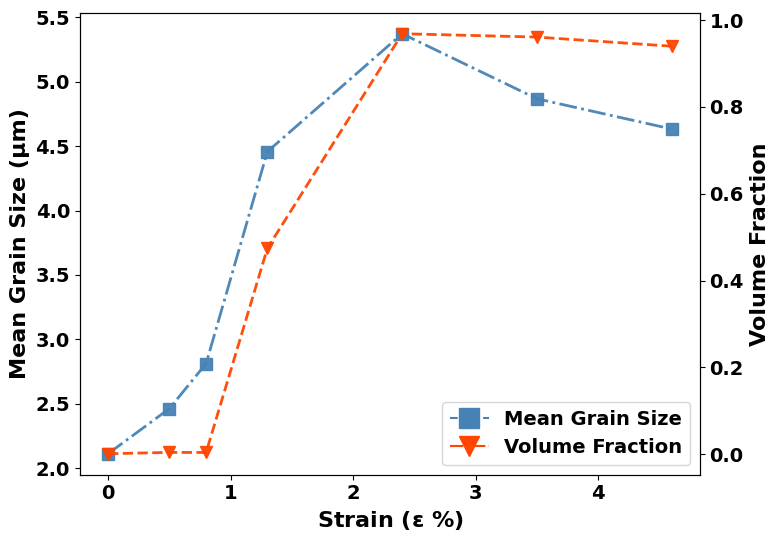

In [ ]:
import matplotlib.lines as mlines
strain_percent = []
for i in range(len(strain)):
    strain_percent.append(strain[i]*100)
print(strain_percent)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(strain_percent[:7], mean_sizes[:7], label='Mean Grain Size', color='steelblue', lw = 2, marker='s', markersize=8, linestyle='-.', alpha=0.95)  
ax2.plot(strain_percent[:7], v_frac[:7], label='Volume Fraction', color='orangered', lw = 2, marker='v', markersize=8, linestyle='dashed', alpha=0.95)   
ax1.set_xlabel('Strain ($\epsilon$ %)', fontsize=16)
ax1.set_ylabel('Mean Grain Size (μm)', fontsize=16)
ax2.set_ylabel('Volume Fraction', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
red_line = mlines.Line2D([], [], color='steelblue', marker='s', markersize=14, label='Mean Grain Size', linestyle='--')
blue_line = mlines.Line2D([], [], color = 'orangered', marker='v', markersize=14, label='Volume Fraction', linestyle='-.')
plt.legend(handles=[red_line, blue_line], loc='lower right', fontsize=14)
image_dir = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\Documents\\DTU_Project\\data\\Figures\\First_sample_of_PhD\\fig_Albert_TMS'
#plt.savefig(os.path.join(image_dir, f'meansize_vf.png'), dpi=600)
plt.show()


#fig, ax1 = plt.subplots(figsize=(8, 6))
#ax2 = ax1.twinx()
#ax1.plot(strain_percent[3:7], mean_sizes[3:7], label='Mean Grain Size', color='darkorange', lw = 2, marker='X', markersize=10, linestyle='-.', alpha=0.8)  
#ax2.plot(strain_percent[3:7], std_sizes[3:7], label='Volume Fraction', color='navy', lw = 2, marker='v', markersize=10, linestyle='dashed', alpha=0.8)   
#ax1.set_xlabel('Strain ($\epsilon$)', fontsize=16)
#ax1.set_ylabel('Mean Grain Size (μm)', fontsize=16)
#ax2.set_ylabel('Sigma (μm)', fontsize=16)
#ax1.tick_params(axis='both', which='major', labelsize=14)
#ax2.tick_params(axis='y', which='major', labelsize=14)
#red_line = mlines.Line2D([], [], color='darkorange', marker='X', markersize=14, label='Mean Grain Size', linestyle='--')
#blue_line = mlines.Line2D([], [], marker='v', markersize=14, label='Sigma', linestyle='-.')
#plt.legend(handles=[red_line, blue_line], loc='lower right', fontsize=14)
#plt.show()


#plt.plot(strain[3:7], mean_misorientations[3:7], label='Mean Misorientation')
#plt.plot(strain[3:7], std_misorientations[3:7], label='Std Misorientation')
#plt.xlabel('Strain')
#plt.ylabel('Mean Misorientation')
#plt.legend()
#plt.show()

#plt.plot(strain[3:7], mean_gauss1[3:7], label='Mean Gauss1')
#plt.plot(strain[3:7], mean_gauss2[3:7], label='Mean Gauss2')
#plt.plot(strain[3:7], std_gauss1[3:7], label='Std Gauss1')
#plt.plot(strain[3:7], std_gauss2[3:7], label='Std Gauss2')
#plt.xlabel('Strain')
#plt.ylabel('Mean Gauss1')
#plt.legend()
#plt.show()


Area ratio of FWHM mask:12.53% with threshold 0.15


(0.0, 1031.6175, 0.0, 371.28700000000003)

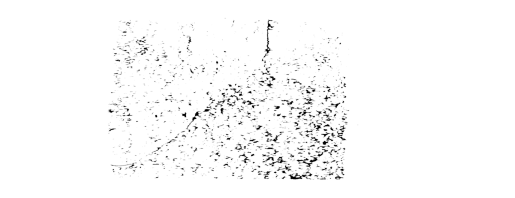

In [ ]:
j=1 # index of the file to be processed
# Load the FWHM data
Img_chi, maximum_chi, minimum_chi, average_chi, TF_chi, row_size_chi, col_size_chi, _ = process_data(path, com_chi[j], method='COM')
grain = find_grain(TF_chi)
FWHM_chi, maximum_chi, minimum_chi, average_chi, TF_chi, row_size_chi, col_size_chi, _ = process_data(path, fwhm_chi[j], method='FWHM', grain_mask=grain)
FWHM_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, fwhm_phi[j], method='FWHM', grain_mask=grain)

FWHM_img = np.sqrt(FWHM_chi**2 + FWHM_phi**2)

FWHM_img[FWHM_img > 4] = 4

fwhm_filter = calculate_FWHM(FWHM_img, grain, row_size_chi, col_size_chi, 0.15, kernelSize=2)

fwhm_filter = binary_erosion(fwhm_filter, disk(1))
#fwhm_filter = binary_dilation(fwhm_filter, disk(1))

#fwhm_filter = fwhm_filter[top:bottom, left:right]

plt.imshow(fwhm_filter, cmap='Greys', extent=[0, pixel_x * row_size_chi, 0, pixel_y * col_size_chi], vmin=0, vmax=1)
plt.axis('off')
